In [1]:
import pandas as pd
import pickle
%pylab inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures,RobustScaler

import scipy.stats as stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
horror_df=pd.read_pickle('horror_df.pkl')
horror_df

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Novel_Adaptation,Male_Score,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder
0,Psycho,1960,109,"[Horror, Mystery, Thriller ]",8.5,602815,97,Alfred Hitchcock,"[Anthony Perkins, Janet Leigh, Vera Miles]",806947,...,1,8.5,353389,8.4,88145,/title/tt0054215/,0,0,1,1
1,The Shining,1980,146,"[Drama, Horror ]",8.4,896027,66,Stanley Kubrick,"[Jack Nicholson, Shelley Duvall, Danny Lloyd]",19000000,...,1,8.4,530475,8.3,124287,/title/tt0081505/,0,0,1,1
2,Alien,1979,117,"[Horror, Sci-Fi ]",8.4,786083,89,Ridley Scott,"[Sigourney Weaver, Tom Skerritt, John Hurt]",11000000,...,0,8.5,507612,8.2,73461,/title/tt0078748/,1,1,1,1
3,The Thing,1982,109,"[Horror, Mystery, Sci-Fi ]",8.1,370424,57,John Carpenter,"[Kurt Russell, Wilford Brimley, Keith David]",15000000,...,0,8.2,252886,7.7,28831,/title/tt0084787/,0,1,1,1
4,What Ever Happened to Baby Jane?,1962,134,"[Drama, Horror, Thriller ]",8.1,49967,75,Robert Aldrich,"[Bette Davis, Joan Crawford, Victor Buono]",980000,...,1,8.0,28768,8.3,10292,/title/tt0056687/,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,0,3.2,14850,3.4,4180,/title/tt5690360/,0,1,0,1
680,Jaws: The Revenge,1987,89,"[Adventure, Horror, Thriller ]",3.0,41154,15,Joseph Sargent,"[Lorraine Gary, Lance Guest, Mario Van Peebles]",23000000,...,0,2.9,27697,3.6,3417,/title/tt0093300/,0,0,0,0
681,BloodRayne,2005,95,"[Action, Fantasy, Horror ]",2.9,34131,18,Uwe Boll,"[Kristanna Loken, Ben Kingsley, Michelle Rodri...",25000000,...,0,2.9,25173,3.1,3255,/title/tt0383222/,1,0,1,1
682,Alone in the Dark,2005,96,"[Action, Horror, Sci-Fi ]",2.4,41668,9,Uwe Boll,"[Christian Slater, Tara Reid, Stephen Dorff]",20000000,...,0,2.3,30832,2.6,3395,/title/tt0369226/,0,1,1,1


In [3]:
#removing outlier residuals

horror_df=horror_df.drop([681])
horror_df=horror_df.drop([682])
horror_df=horror_df.drop([683])
horror_df=horror_df.drop([668])

In [4]:
#sns.pairplot(horror_df,plot_kws=dict(alpha=.2,edgecolor='none'));

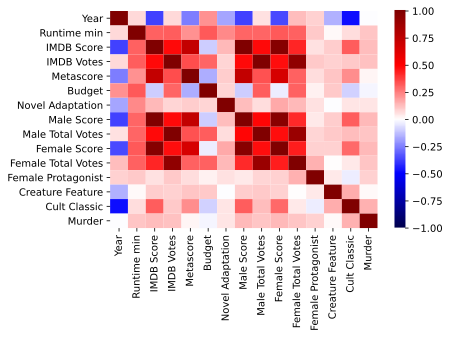

In [5]:
horror_df1=horror_df
horror_df1.columns = horror_df1.columns.str.replace('_',' ')
horror_df1.corr()
sns.heatmap(horror_df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
plt.savefig('horror_heatmap.svg',format='svg')

In [6]:
horror_df.columns = horror_df.columns.str.replace(' ','_')
X=horror_df.loc[:,['Year','Runtime_min','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Budget']]
y=horror_df['Female_Score']

In [7]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,X],axis=1)
X=combined_X
y=horror_df['Female_Score']

In [8]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
X['Director']=horror_df['Director'].replace(other_d,'Other')
X=pd.get_dummies(X,drop_first=True)
y=horror_df['Female_Score']

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [10]:
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Female_Score   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     4.549
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           1.17e-19
Time:                        16:19:12   Log-Likelihood:                -404.42
No. Observations:                 408   AIC:                             930.8
Df Residuals:                     347   BIC:                             1176.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           44.6490      4.972      8.980      0.000      34.870      54.428
 Adventure                       0.2217      0.298      0.744      0.458      -0.365       0.808
 Comedy                          0.2085      0.322      0.647      0.518      -0.425       0.842
 Comedy                          4.9416      0.740      6.677      0.000       3.486       6.397
 Crime                           0.5930      0.380      1.562      0.119      -0.154       1.340
 Crime                           4.4157      0.625      7.060      0.000       3.185       5.646
 Drama                           0.2909      0.248      1.174      0.241      -0.197       0.778
 Drama                           4.3691      0.616      7.089      0.000       3.157       5.581
 Family                         -0.3545      0.555     -0.639      0.523      -1.446       0.737
 Family                          5.1910      0.717      7.241      0.000       3.781       6.601
 Fantasy                         0.1652      0.191      0.863      0.389      -0.211       0.542
 Fantasy                         4.1515      0.532      7.803      0.000       3.105       5.198
 History                        -0.3419      0.772     -0.443      0.658      -1.860       1.176
 Horror                          2.8432      0.389      7.302      0.000       2.077       3.609
 Horror                          4.2321      0.520      8.140      0.000       3.210       5.255
 Music                           1.0080      0.743      1.357      0.176      -0.453       2.469
 Musical                         1.7066      0.844      2.023      0.044       0.047       3.366
 Musical                         2.1293      0.535      3.983      0.000       1.078       3.181
 Mystery                         0.0629      0.142      0.442      0.659      -0.217       0.343
 Mystery                         1.4340      0.248      5.780      0.000       0.946       1.922
 Romance                         0.8612      0.497      1.732      0.084      -0.117       1.839
 Sci-Fi                          0.4743      0.277      1.715      0.087      -0.070       1.018
 Sci-Fi                          1.4511      0.239      6.076      0.000       0.981       1.921
 Thriller                        1.5622      0.239      6.545      0.000       1.093       2.032
 Western                         1.7969      0.666      2.696      0.007       0.486       3.108
Action                           3.7950      0.459      8.276      0.000       2.893       4.697
Adventure                        3.2442      0.445      7.287      0.000       2.369       4.120
Animation                        4.1946      0.724      5.792      0.000       2.770       5.619
Biography                        3.3724      0.836      4.035      0.000    

In [11]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
val_score=lr_model.score(X_val,y_val)
val_score

0.13802684123041853

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=41)

In [13]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
robust_pred=pipe.predict(X_test)

In [14]:
r2_score(y_test,robust_pred)

0.30530149924746564

In [15]:
ridge_coef=list(zip(X_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
ridge_coef
filtered=[(coef,val) for coef,val in ridge_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Creature_Feature', 0.0011466886216167272),
 ('Action', 0.0028583269695803028),
 (' Crime            ', -0.006797352618272547),
 (' Western            ', 0.012312504586699989),
 ('Biography', -0.0212541409665435),
 (' Romance            ', -0.029897754105442445),
 (' Adventure', 0.03043299091986613),
 (' Fantasy            ', 0.03067553100319876),
 (' Fantasy', 0.03075541631162871),
 (' Sci-Fi            ', -0.032846822489741995),
 (' Mystery', 0.033950646329484704),
 ('Director_Joe Dante', -0.03439368162393982),
 ('Director_Paul W.S. Anderson', 0.036383784364089115),
 (' Horror            ', -0.03651215698255446),
 ('Director_Greg McLean', -0.037169250500347584),
 ('Fantasy', 0.04228248470309639),
 ('Comedy', 0.04887195121140915),
 (' Horror', -0.04980011562385761),
 (' Comedy            ', 0.05518612349676375),
 ('Director_Alexandre Aja', -0.057089854922650445),
 (' History', -0.05958469534851382),
 ('Novel_Adaptation', 0.06314392720611108),
 ('Director_Eli Roth', -0.06818770001112

In [16]:
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipeL=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipeL.fit(X_train,y_train)
robust_predL=pipeL.predict(X_test)

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.43482653388952, tolerance: 0.03408914942528737
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.47313542565233, tolerance: 0.033274197701149436
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.66082819352674, tolerance: 0.03332474942528736
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.70708634822512, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.96995810567427, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.6645369971293, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarnin

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.70711930265298, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.96999148979661, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.66456957029794, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarni

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.70724985417212, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.9701242290795, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.66470213916313, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarnin

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.70777709621763, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.97066113465691, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.66523677968536, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarni

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.97282818939898, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.66739475530197, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.43574853963555, tolerance: 0.03408914942528737
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conve

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.71848898781727, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.98156757125533, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.67609927972877, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarni

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.9072320411471, tolerance: 1.6723029999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.1092350074439, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.75302623761708, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.47561336022506, tolerance: 0.033221370114942535
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.50793747326094, tolerance: 0.034324722477064216
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.04673037668618, tolerance: 1.6723029999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.75478299899841, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.41505457563818, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.68004610475204, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Conver

/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.91156108838126, tolerance: 1.6723029999999999
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.02821576777461, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.58904195911204, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

In [17]:
r2_score(y_test,robust_predL)

0.28899256953660013

In [18]:
lasso_coef=list(zip(X_train.columns, pipeL.named_steps['search'].best_estimator_.coef_))
lasso_coef
filteredL=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filteredL,key=lambda x: abs(x[1]))

[('Comedy', 0.00022181894134672053),
 ('Director_Christopher Landon', 0.009502794059849561),
 (' Horror            ', -0.014665668849514625),
 ('Novel_Adaptation', 0.024983121601172137),
 ('Horror            ', -0.04844664117794218),
 (' Fantasy            ', 0.048732064814365865),
 ('Director_Mike Flanagan', 0.04928932753063799),
 ('Crime', 0.05158130317808582),
 ('Director_Guillermo del Toro', 0.056746139837977744),
 ('Budget', -0.06899910299503755),
 ('Director_George A. Romero', -0.07081432598765143),
 ('Cult_Classic', 0.08632126664231846),
 (' Thriller            ', -0.09185584886826022),
 ('Horror', -0.13349329405814603),
 (' Family            ', 0.13527850891658935),
 ('Director_Sam Raimi', 0.13559082224952385),
 (' Mystery            ', -0.1433617414608015),
 (' Drama', 0.1474436685954088),
 ('Director_Other', -0.15958464845791273),
 ('Murder', 0.1659244019890566),
 ('Drama', 0.1985182098986305),
 (' Sci-Fi', 0.19895922821276976),
 ('Female_Protagonist', 0.21331132601510366),
 

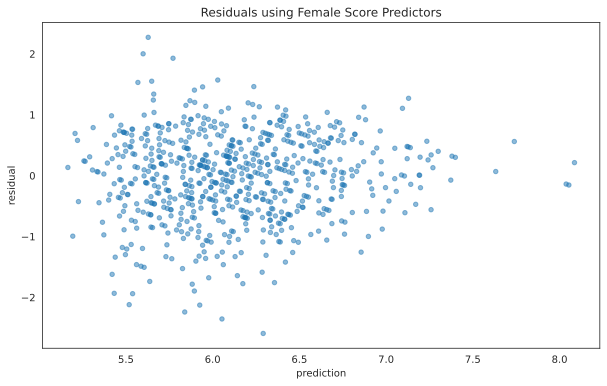

In [19]:
horror_df['prediction']=pipe.predict(X)
horror_df['residual']=y-horror_df.prediction
with sns.axes_style('white'):
    plot=horror_df.plot(kind='scatter',
                  x='prediction',y='residual',alpha=0.5,figsize=(10,6))
plt.title('Residuals using Female Score Predictors')
plt.savefig('fem_pred_residual_scatter.svg',format='svg')

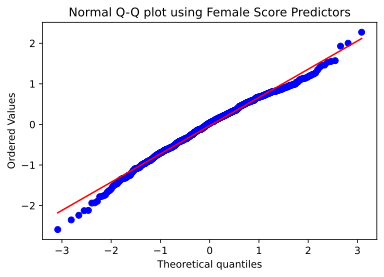

In [20]:
stats.probplot(horror_df['residual'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot using Female Score Predictors")
plt.savefig('Fem_pred_qq.svg',format='svg')
plt.show()


In [21]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, robust_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, robust_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, robust_pred)))

Mean Absolute Error: 0.5183382409491619
Mean Squared Error: 0.4493710736690923
Root Mean Squared Error: 0.6703514553345076


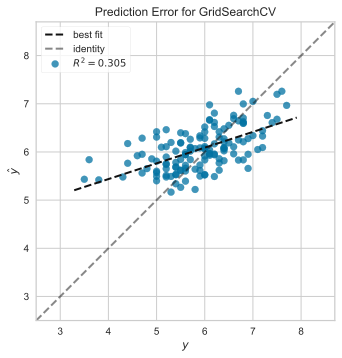

In [22]:
from yellowbrick.regressor import PredictionError
visualizer=PredictionError(pipe)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
plt.title('Predition Error for Ridge Regression')
plt.savefig('Fem_Pred_Error.svg',format='svg')
visualizer.show();

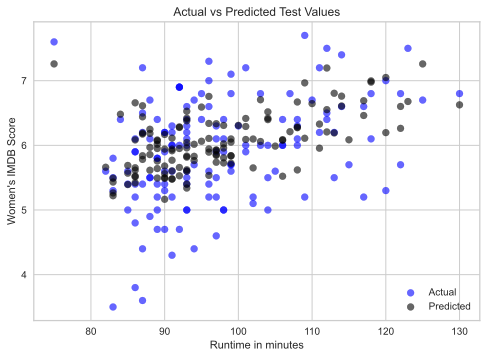

In [23]:
#plt.scatter(X_train['Runtime_min'],y_train, color='red')
plt.scatter(X_test['Runtime_min'],y_test, color='blue', alpha=0.6,label="Actual") #actual
plt.scatter(X_test['Runtime_min'],robust_pred, color="black", alpha=0.6,label="Predicted") #predicted
plt.title('Actual vs Predicted Test Values')
plt.ylabel("Women's IMDB Score")
plt.xlabel("Runtime in minutes")
plt.legend(); 
plt.savefig('runtime_predicted_actual_scatter.svg',format='svg')

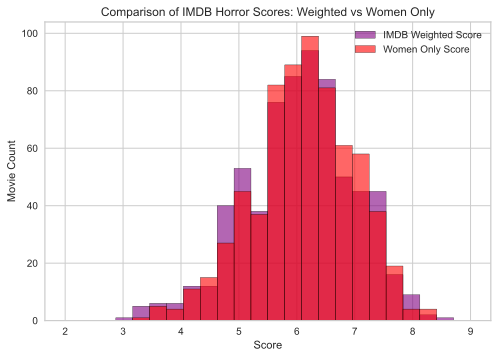

In [32]:
bins=np.linspace(2,9,25)
sns.histplot(horror_df.IMDB_Score,alpha=0.6,color='purple', label='IMDB Weighted Score',bins=bins)
sns.histplot(horror_df.Female_Score,alpha=0.6,color='red',label='Women Only Score',bins=bins)
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Women Only')
plt.legend();
plt.savefig('IMDB_Weighted_Women_hist.svg',format='svg')

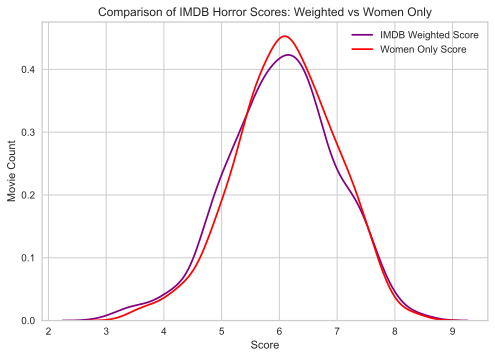

In [33]:
bins=np.linspace(2,9,25)
sns.kdeplot(horror_df.IMDB_Score,alpha=0.6,color='purple', label='IMDB Weighted Score')
sns.kdeplot(horror_df.Female_Score,alpha=0.6,color='red',label='Women Only Score')
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Women Only')
plt.legend();
plt.savefig('IMDB_Weighted_Women_kde.svg',format='svg')

In [25]:
horror_df['IMDB_Female_Diff']=abs(horror_df['IMDB_Score']-horror_df['Female_Score'])
horror_df['IMDB_Female_Diff'].mean()

0.1736764705882353

In [26]:
horror_df['IMDB_Male_Diff']=abs(horror_df['IMDB_Score']-horror_df['Male_Score'])
horror_df['IMDB_Male_Diff'].mean()

0.04235294117647058

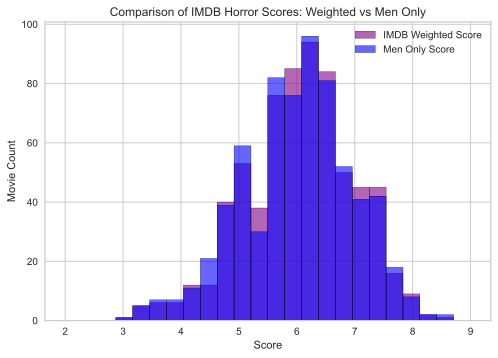

In [34]:
bins=np.linspace(2,9,25)
sns.histplot(horror_df.IMDB_Score,color='purple', alpha=0.6, label='IMDB Weighted Score',bins=bins)
sns.histplot(horror_df.Male_Score,color='blue', alpha=0.6,label='Men Only Score',bins=bins)
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Men Only')
plt.legend();
plt.savefig('IMDB_Weighted_Men_hist.svg',format='svg')

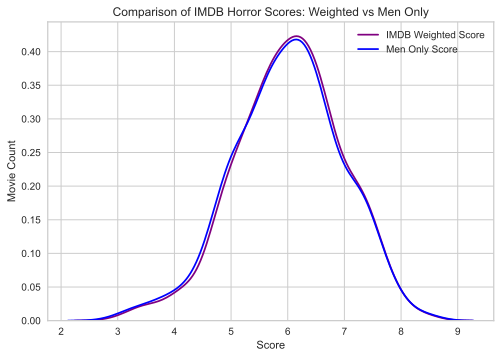

In [35]:
bins=np.linspace(2,9,25)
sns.kdeplot(horror_df.IMDB_Score,color='purple', alpha=0.6, label='IMDB Weighted Score')
sns.kdeplot(horror_df.Male_Score,color='blue', alpha=0.6,label='Men Only Score')
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores: Weighted vs Men Only')
plt.legend();
plt.savefig('IMDB_Weighted_Men_kde.svg',format='svg')

In [ ]:
sns.regplot(x="Runtime_min",y="Female_Score",data=horror_df)
plt.title('Regression Plot using Runtime')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Female IMDB Score');
plt.savefig('Regression_Plot_Runtime_Feature.svg', format='svg')